# 電波ポインティング解析

## 初期処理
- 以下の定数 (大文字の変数名のもの) を各自で設定すること
  - `sys.path` の操作については PyPl ではなくローカルのパッケージを使いたい時に使用すること

In [1]:
# ======================================================================
DATETIME = "20240908_045923"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
PLANET = "sun"  # 観測対象  e.g. "sun", "moon"
RAWDATA_PATH = f"./necst_radiopointing_{DATETIME}_{PLANET}"  # 観測データのパス
SPECTRAL_NAME = "necst-OMU1P85M-data-spectral-None-board2"  # 解析に使用する分光データのファイル名
SAVE_PATH = f"./{DATETIME}_{PLANET}"  # 解析結果の保存先

PATH_NERCST = "/Users/kirby/GitHub/nercst"
PATH_NECLIB = "/Users/kirby/GitHub/neclib"
# ======================================================================
import pprint
import sys

if PATH_NERCST not in sys.path:
    sys.path.insert(0, PATH_NERCST)
if PATH_NECLIB not in sys.path:
    sys.path.insert(0, PATH_NECLIB)
pprint.pprint(sys.path)
# ======================================================================

['/Users/kirby/GitHub/neclib',
 '/Users/kirby/GitHub/nercst',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python39.zip',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python3.9',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python3.9/lib-dynload',
 '',
 '/Users/kirby/Library/CloudStorage/GoogleDrive-ryo106.n67@gmail.com/その他のパソコン/マイ '
 'ノートパソコン/Astro/NECST/sunscan/.venv/lib/python3.9/site-packages']


- 以降は設定不要

In [2]:
%matplotlib inline
import bisect
import math
from typing import List, Literal, Tuple

import nercst
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from astropy.convolution import Box1DKernel, convolve
from scipy import optimize
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import get_body, AltAz
from astropy import units as u
from neclib.coordinates import PointingError

from neclib import config
from neclib.core import Parameters

2025-01-20 02:50:11,240: [ERROR: configuration.py#L228] No telescope specified, using default config....
2025-01-20 02:50:11,241: [INFO: configuration.py#L236] Importing configuration from '/Users/kirby/.necst/config.toml'


In [3]:
print(nercst.__path__)
import neclib
print(neclib.__path__)

['/Users/kirby/GitHub/nercst/nercst']
['/Users/kirby/GitHub/neclib/neclib']


# a1, a2, a3, b1, b2, b3, g1 の計算

本来光学ポインティングで行うフィッティング<br>
後の d1, d2 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- a1：Az-El の非直交性
- a2：光学軸と El 軸の非直交性
- a3：Az エンコーダのオフセット
- b1：天頂からの Az 軸の傾き (南北方向)
- b2：天頂からの El 軸の傾き (東西方向)
- b3：El エンコーダのオフセット
- g1：重力の影響によるオフセット

## 定数や関数の定義
- 以下の定数は再設定したい場合のみ指定すること

In [36]:
# ======================================================================
DATETIME = "20241205-1206"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
PLANET = "sun"  # 観測対象  e.g. "sun", "moon"
RAWDATA_PATH = f"./{DATETIME}_{PLANET}"  # 観測データのパス
PARAM_FILE = "d_param.csv"  # エッジ検出結果のファイル名
# ======================================================================
SAVE_PATH = f"./{DATETIME}_{PLANET}"  # 解析結果の保存先
# ======================================================================
print(f"Previous ``pointing_param.toml`` will be found in {RAWDATA_PATH!r}.")
print(f"Analysis target data is {SAVE_PATH!r}.")
rawdata_path = Path(RAWDATA_PATH)
save_path = Path(SAVE_PATH)
# ======================================================================

Previous ``pointing_param.toml`` will be found in './20241205-1206_sun'.
Analysis target data is './20241205-1206_sun'.


- 以降は設定不要

In [37]:
# RAWDATA_PATH = "./necst_radiopointing_20230330_121827_moon"
# dir_save = f"./1p85m_analy/20230330_csv/{PLANET}_{data_num}"

# date = "20240525_1"
# dbname = "necst_opticalpointing_20240525_113626"

data_dir = save_path
# pic_dir = "pics" + "/" + date +"/"
kisa_file = rawdata_path / "pointing_param.toml"
figs = save_path

In [38]:
def write_param(filepath, model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="deg"):
    with open(filepath, mode="w") as file:
        param = (
            f'[metadata]\n'
            f'model = "{model}"\n'
            f'\n'
            f'[pointing_params]\n'
            f'"a1[{unit}]" = {a1.to(unit).value}\n'
            f'"a2[{unit}]" = {a2.to(unit).value}\n'
            f'"a3[{unit}]" = {a3.to(unit).value}\n'
            f'"b1[{unit}]" = {b1.to(unit).value}\n'
            f'"b2[{unit}]" = {b2.to(unit).value}\n'
            f'"b3[{unit}]" = {b3.to(unit).value}\n'
            f'g1 = {g1}\n'
            f'"c1[{unit}]" = {c1.to(unit).value}\n'
            f'"c2[{unit}]" = {c2.to(unit).value}\n'
            f'"d1[{unit}]" = {d1.to(unit).value}\n'
            f'"d2[{unit}]" = {d2.to(unit).value}\n'
            f'"e1[{unit}]" = {e1.to(unit).value}\n'
            f'"e2[{unit}]" = {e2.to(unit).value}\n'
        )
        file.write(param)
    print(f"======= {filepath!r} =======")
    print(param)

In [39]:
param_before = Parameters.from_file(kisa_file)
def apply_kisa():
        if param_before.model != "omu1p85m":
                raise NotImplementedError(f"This analysis is only for model omu1p85m, not {param_before.model}.")
        # fkisa = open(kisa_file,"r")
        # kisa = fkisa.readlines()
        param_delta = Parameters.from_file(data_dir / "pointing_param_delta.toml")
        # fdkisa = open(f"{data_dir}/pointing_param_delta", "r")
        # dkisa = fdkisa.readlines()
        a1 = param_before.a1 + param_delta.a1
        a2 = param_before.a2 + param_delta.a2
        a3 = param_before.a3 + param_delta.a3
        b1 = param_before.b1 + param_delta.b1
        b2 = param_before.b2 + param_delta.b2
        b3 = param_before.b3 + param_delta.b3
        g1 = param_before.g1 + param_delta.g1
        c1 = param_before.c1 + param_delta.c1
        c2 = param_before.c2 + param_delta.c2
        d1 = param_before.d1 + param_delta.d1
        d2 = param_before.d2 + param_delta.d2
        e1 = param_before.e1 + param_delta.e1
        e2 = param_before.e2 + param_delta.e2
        # fkisa.close()

        # old_kisa_file = f"{data_dir}/pointing_param_before.toml"
        # shutil.copy(kisa_file, old_kisa_file)
        # print("``pointing_param_before.toml`` was created.")

        write_param(data_dir / "pointing_param_after.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
        # nkisa = open(kisa_file,"w")
        # param_new = (f'[metadata]\n'
        #              f'model = "{param.model}"\n'
        #              f'\n'
        #              f'[pointing_params]\n'
        #              f'"a1[deg]" = {a1.to("deg").value}\n'
        #              f'"a2[deg]" = {a2.to("deg").value}\n'
        #              f'"a3[deg]" = {a3.to("deg").value}\n'
        #              f'"b1[deg]" = {b1.to("deg").value}\n'
        #              f'"b2[deg]" = {b2.to("deg").value}\n'
        #              f'"b3[deg]" = {b3.to("deg").value}\n'
        #              f'g1 = {g1}\n'
        #              f'"c1[deg]" = {c1.to("deg").value}\n'
        #              f'"c2[deg]" = {c2.to("deg").value}\n'
        #              f'"d1[deg]" = {d1.to("deg").value}\n'
        #              f'"d2[deg]" = {d2.to("deg").value}\n'
        #              f'"e1[deg]" = {e1.to("deg").value}\n'
        #              f'"e2[deg]" = {e2.to("deg").value}\n')
        # nkisa.write(param_new)
        # nkisa.write(str(a1)+"\n")
        # nkisa.write(str(a2)+"\n")
        # nkisa.write(str(a3)+"\n")
        # nkisa.write(str(b1)+"\n")
        # nkisa.write(str(b2)+"\n")
        # nkisa.write(str(b3)+"\n")
        # nkisa.write(str(g1)+"\n")
        # nkisa.write(str(c1)+"\n")
        # nkisa.write(str(c2)+"\n")
        # nkisa.write(str(d1)+"\n")
        # nkisa.write(str(d2)+"\n")    
        # nkisa.write(str(e1)+"\n")
        # nkisa.write(str(e2)+"\n")
        # nkisa.close()

        # new_kisa_file = data_dir + "pointing_param_after.toml"
      #  shutil.copy(f"{data_dir}/pointing_param_after.toml", kisa_file)
       # print("``pointing_param_after.toml`` was created and pointing_param was updated.")
       # print("Data location : " + data_dir)
       # print("======= ``pointing_param_delta.toml`` =======")
       # print(param_delta)
        # print(a1)
        # print(a2)
        # print(a3)
        # print(b1)
        # print(b2)
        # print(b3)
        # print(g1)
        # print(c1)
        # print(c2)
        # print(d1)
        # print(d2)
        # print(e1)
        # print(e2)

## ここから実処理

In [40]:
csv = pd.read_csv(save_path / PARAM_FILE)
csv

,dt_cross_id,scan_id,cross_id,axis,dx,dEl,Az,El
0,20241204_231751_1,2.0,1.0,0.0,3.214119,NaN,136.340969,15.223443
1,20241205_024401_0,0.0,0.0,0.0,3.955620,NaN,184.796104,31.043087
2,20241205_024401_0,1.0,0.0,1.0,NaN,-5.545609,185.012955,31.035916
3,20241205_025904_0,0.0,0.0,0.0,6.018956,NaN,188.711808,30.820158
4,20241205_025904_0,1.0,0.0,1.0,NaN,-5.089253,188.927251,30.802181
...,...,...,...,...,...,...,...,...
517,20241206_041714_49,99.0,49.0,1.0,NaN,0.045783,226.422920,16.603520
518,20241206_041714_50,100.0,50.0,0.0,-14.260888,NaN,226.576026,16.491085
519,20241206_041714_50,101.0,50.0,1.0,NaN,8.505880,226.728792,16.378425
520,20241206_041714_51,102.0,51.0,0.0,-8.817967,NaN,226.881216,16.265372


In [41]:
csv_az = csv.dropna(subset=["dx"])
csv_el = csv.dropna(subset=["dEl"])
csv_union = pd.DataFrame(columns=["dt_cross_id", "cross_id", "dx", "dEl", "Az", "El"])
for _dt_cross_id in np.unique(csv.dt_cross_id):
    if _dt_cross_id not in csv_az.dt_cross_id.values or _dt_cross_id not in csv_el.dt_cross_id.values:
        continue
    cross_id = csv[csv.dt_cross_id == _dt_cross_id].cross_id.values[0]
    dx = csv_az[csv_az.dt_cross_id == _dt_cross_id].dx.values[0]
    dEl = csv_el[csv_el.dt_cross_id == _dt_cross_id].dEl.values[0]
    Az = (csv_az[csv_az.dt_cross_id == _dt_cross_id].Az.values[0] + csv_el[csv_el.dt_cross_id == _dt_cross_id].Az.values[0]) / 2
    El = (csv_az[csv_az.dt_cross_id == _dt_cross_id].El.values[0] + csv_el[csv_el.dt_cross_id == _dt_cross_id].El.values[0]) / 2
    csv_union = csv_union.append({"dt_cross_id": _dt_cross_id, "cross_id": cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
# idx=np.argsort(csv_union["cross_id"])
# csv_union=csv_union.iloc[idx]
csv_union

/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_93970/3273228700.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"dt_cross_id": _dt_cross_id, "cross_id": cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_93970/3273228700.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"dt_cross_id": _dt_cross_id, "cross_id": cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_93970/3273228700.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"dt_cross_id": _dt_cross_id, "

,dt_cross_id,cross_id,dx,dEl,Az,El
0,20241205_024401_0,0.0,3.955620,-5.545609,184.904530,31.039502
1,20241205_025904_0,0.0,6.018956,-5.089253,188.819530,30.811169
2,20241205_025904_1,1.0,-1.606399,-4.789220,189.260283,30.772946
3,20241205_025904_10,10.0,2.678329,-5.541041,193.234237,30.310526
4,20241205_025904_100,100.0,-11.208265,11.184303,227.790150,15.733099
...,...,...,...,...,...,...
254,20241206_041714_51,51.0,-8.817967,13.393499,226.957258,16.208762
255,20241206_041714_6,6.0,4.214394,-6.635203,211.114073,25.279323
256,20241206_041714_7,7.0,-0.219206,-10.196140,211.485570,25.123089
257,20241206_041714_8,8.0,2.914912,-5.364686,211.855621,24.964935


In [42]:
# rms の計算
dx_sigma = np.nanstd(csv["dx"])
dx_rms = np.sqrt(np.nanmean(csv["dx"] ** 2))
dy_sigma = np.nanstd(csv["dEl"])
dy_rms = np.sqrt(np.nanmean(csv["dx"] ** 2))
d_sigma = np.sqrt(dx_sigma ** 2 + dy_sigma ** 2)

print(f"sigma = {d_sigma:.2f} arcsec")

dx_mean = csv_az["dx"].mean()
dy_mean = csv_el["dEl"].mean()
print(f"dx_mean = {dx_mean:.2f} arcsec")
print(f"dy_mean = {dy_mean:.2f} arcsec")
dx_mean_deg = dx_mean / 3600
dy_mean_deg = dy_mean / 3600

sigma = 10.91 arcsec
dx_mean = -0.04 arcsec
dy_mean = 0.89 arcsec


In [43]:
def f_az2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    # return np.cos(el) * ((a1 * np.tan(el)) + (a2 / np.cos(el)) + a3 + (b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / np.cos(el))
    return (a1 * np.sin(el) + a2 + a3 * np.cos(el) + b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / 1  # np.cos(el)  # deg

def f_az3(X, c1, c2, d1, d2):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    return (c1 * np.sin(az - el) + c2 * np.cos(az - el) + d1) / 1  # np.cos(el)  # deg

def f_az4(X, c1, c2, d1, d2, e1, e2):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    return (c1 * np.sin(az - el) + c2 * np.cos(az - el) + d1 + e1 * np.cos(el) - e2 * np.sin(el)) / 1  # np.cos(el)  # deg

def f_el2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    return b1 * np.cos(az) + b2 * np.sin(az) + b3 + g1 * _el  # deg

def f_el3(X, c1, c2, d1, d2):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    return c1 * np.cos(az - el) - c2 * np.sin(az - el) + d2  # deg

def f_el4(X, c1, c2, d1, d2, e1, e2):
    _az, _el = X
    az = _az * np.pi / 180  # deg -> rad
    el = _el * np.pi / 180  # deg -> rad
    return c1 * np.cos(az - el) - c2 * np.sin(az - el) + d2 + e1 * np.sin(el) + e2 * np.cos(el)  # deg

def eval_func(p, az, el, _dx):
    dx = _dx / 3600  # arcsec -> deg
    results_dx = f_az2([az, el], *p)
    return (dx - results_dx) ** 2

def eval_func2(p, az, el, _dy):
    dy = _dy / 3600  # arcsec -> deg
    results_dy = f_el2([az, el],*p)
    return (dy - results_dy) ** 2

def eval_func3(p, az, el, _dx, _dy):
    dx = _dx / 3600  # arcsec -> deg
    dy = _dy / 3600  # arcsec -> deg
    results_dx = f_az2([az, el], *p)
    results_dy = f_el2([az, el], *p)
    return (dx - results_dx) ** 2 + (dy - results_dy) ** 2

def eval_func4(p, az, el, _dx, _dy):
    dx = _dx / 3600  # arcsec -> deg
    dy = _dy / 3600  # arcsec -> deg
    results_dx = f_az3([az, el], *p)
    results_dy = f_el3([az, el], *p)
    return (dx - results_dx) ** 2 + (dy - results_dy) ** 2

def fit_ddx(az, el, dx):
    ...

In [44]:
# print(csv_az["Az"] * u.deg)
# print((3 * u.deg) ** 2)

In [45]:
# opt-p
# pp1 = optimize.least_squares(eval_func, x0=[0,dx_mean_deg,0,0,0,dy_mean_deg,0], args=(csv_az["Az"], csv_az["El"], csv_az["dx"]))
# pp2 = optimize.least_squares(eval_func2, x0=[0,dx_mean_deg,0,0,0,dy_mean_deg,0], args=(csv_el["Az"], csv_el["El"], csv_el["dEl"]))
# print(pp1.x)
# print(pp2.x)
# print(pp1.x * 3600)
# print(pp2.x * 3600)
# pp = list(pp1.x[0:3])+list(pp2.x[3:7])
# print(pp)
# pp3 = optimize.least_squares(eval_func3, x0=pp, args=(csv_union["Az"], csv_union["El"], csv_union["dx"], csv_union["dEl"]))
# print(pp3.x)
# print(pp3.x * 3600)
class Placeholder:
	pass

pp3 = Placeholder()
setattr(pp3, "x", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# radio-p
pp4 = optimize.least_squares(eval_func4, x0=[0,0,dx_mean_deg,dy_mean_deg], args=(csv_union["Az"], csv_union["El"], csv_union["dx"], csv_union["dEl"]))
print(pp4.x)
print(pp4.x * 3600)

[ 0.00176673 -0.0032389  -0.00291707  0.00147045]
[  6.36021074 -11.66003503 -10.50145031   5.2936281 ]


In [46]:
# opt-p
# bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp3.x) * 3600
# bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp3.x) * 3600
# bestfit_union_dx = f_az2([csv_union["Az"],csv_union["El"]], *pp3.x) * 3600
# bestfit_union_dy = f_el2([csv_union["Az"],csv_union["El"]], *pp3.x) * 3600

# radio-p
bestfit_dx = f_az3([csv["Az"],csv["El"]], *pp4.x) * 3600
bestfit_dy = f_el3([csv["Az"],csv["El"]], *pp4.x) * 3600
bestfit_union_dx = f_az3([csv_union["Az"],csv_union["El"]], *pp4.x) * 3600
bestfit_union_dy = f_el3([csv_union["Az"],csv_union["El"]], *pp4.x) * 3600

# debug
# bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp1.x)
# bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp2.x)

# print(len(csv["dx"]))
# print(len(csv["dEl"]))

# print(type(bestfit_dx))
# print(len(bestfit_dy))

# print(type(csv_union["dx"]))
# print(len(csv_union["dEl"]))

print(csv_union['dx']-bestfit_union_dx)

0      1.187579
1      3.327057
2     -4.285038
3      0.166139
4     -7.213160
         ...   
254   -5.085594
255    3.762794
256   -0.601146
257    2.603619
258    2.507030
Length: 259, dtype: float64


In [47]:
bestfit_dx_sigma = np.nanstd(csv["dx"] - bestfit_dx)  # arcsec
bestfit_dy_sigma = np.nanstd(csv["dEl"] - bestfit_dy)  # arcsec
bestfit_union_dx_sigma = np.nanstd(csv_union["dx"] - bestfit_union_dx)  # arcsec
bestfit_union_dy_sigma = np.nanstd(csv_union["dEl"] - bestfit_union_dy)  # arcsec
bestfit_d_sigma = np.sqrt(bestfit_union_dx_sigma**2 + bestfit_union_dy_sigma**2)  # arcsec

print(f"bestfit_sigma = {bestfit_d_sigma:.2f} arcsec")

bestfit_sigma = 7.88 arcsec


In [48]:
# csv["cross_id"][532]
# len(csv)

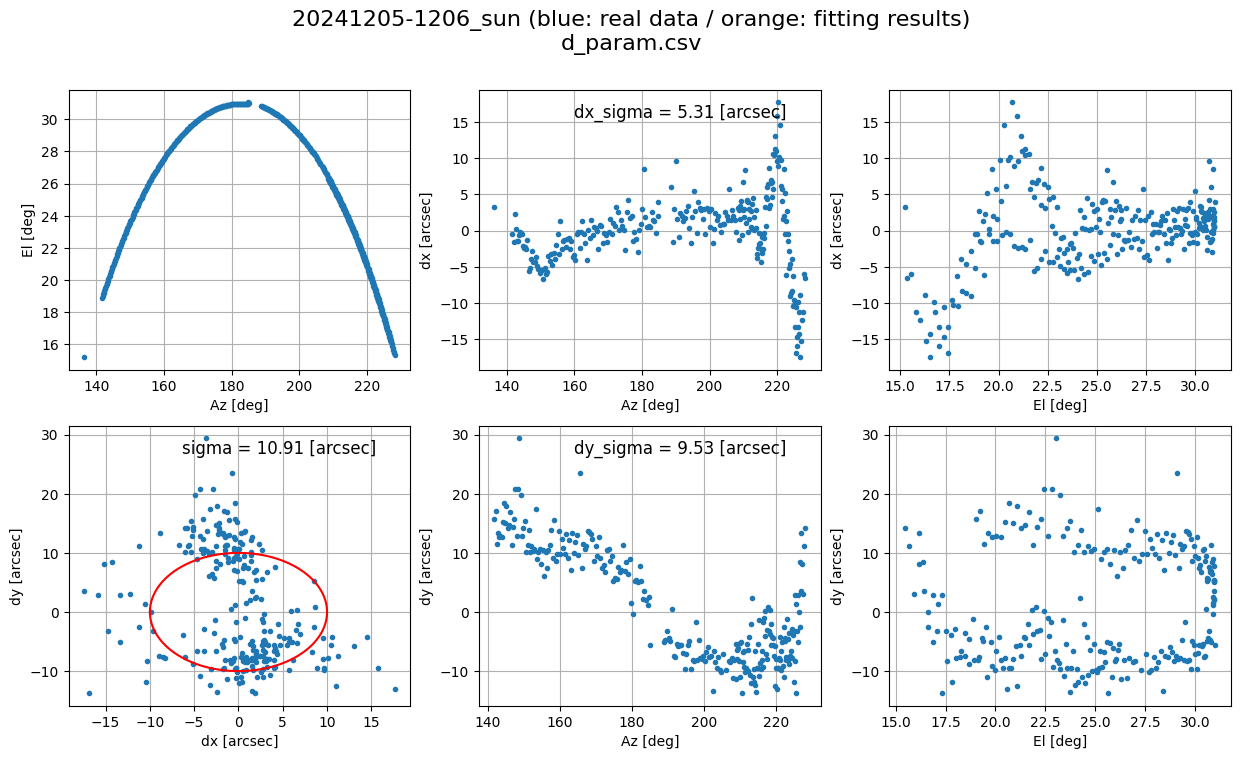

In [49]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]
[_ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]
[_ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]

for i in range(len(csv)):
    _ci = int(csv["cross_id"][i]) % 1  # 6
    kwargs = {"color": f"C{_ci}"}
    ax[0].plot(csv['Az'][i], csv['El'][i], marker='.', **kwargs)
    ax[1].plot(csv['Az'][i], csv['dx'][i], marker='.', **kwargs)
    ax[2].plot(csv['El'][i], csv['dx'][i], marker='.', **kwargs)
    ax[4].plot(csv['Az'][i], csv['dEl'][i], marker='.', **kwargs)
    ax[5].plot(csv['El'][i], csv['dEl'][i], marker='.', **kwargs)

for i in range(len(csv_union)):
    _ci = int(csv_union["cross_id"][i]) % 1  # 6
    kwargs = {"color": f"C{_ci}"}
    ax[3].plot(csv_union['dx'][i], csv_union['dEl'][i], marker='.', **kwargs)

# ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

# ax[1].plot(csv['Az'], csv['dx'], 'o')
ind1=np.argsort(csv['Az'])
# ax[1].plot(csv['Az'][ind1], bestfit_dx[ind1], '.')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, f'dx_sigma = {dx_sigma:.2f} [arcsec]', size=12, ha='right', va='top', transform=ax[1].transAxes,)

# ax[2].plot(csv['El'], csv['dx'], 'o')
ind2=np.argsort(csv['El'])
# ax[2].plot(csv['El'][ind2], bestfit_dx[ind2], '.')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

# ax[3].plot(csv_union['dx'], csv_union['dEl'], 'o')
# ax[3].plot(bestfit_union_dx, bestfit_union_dy, '.')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dy [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

# ax[4].plot(csv['Az'], csv['dEl'], 'o')
# ax[4].plot(csv['Az'][ind1], bestfit_dy[ind1], '.')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dy [arcsec]')
ax[4].text(0.9, 0.95, 'dy_sigma = %0.2f [arcsec]'%dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

# ax[5].plot(csv['El'], csv['dEl'], 'o')
# ax[5].plot(csv['El'][ind2], bestfit_dy[ind2], '.')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dy [arcsec]')

[a.grid(True) for a in ax]

# ax[3].set_ylim(-26, 4)
# ax[4].set_ylim(-26, 4)
# ax[5].set_ylim(-26, 4)


fig.suptitle(f"{str(save_path.name)} (blue: real data / orange: fitting results)\n{PARAM_FILE}", fontsize=16)
fig.savefig(figs / "pointing_results.png")

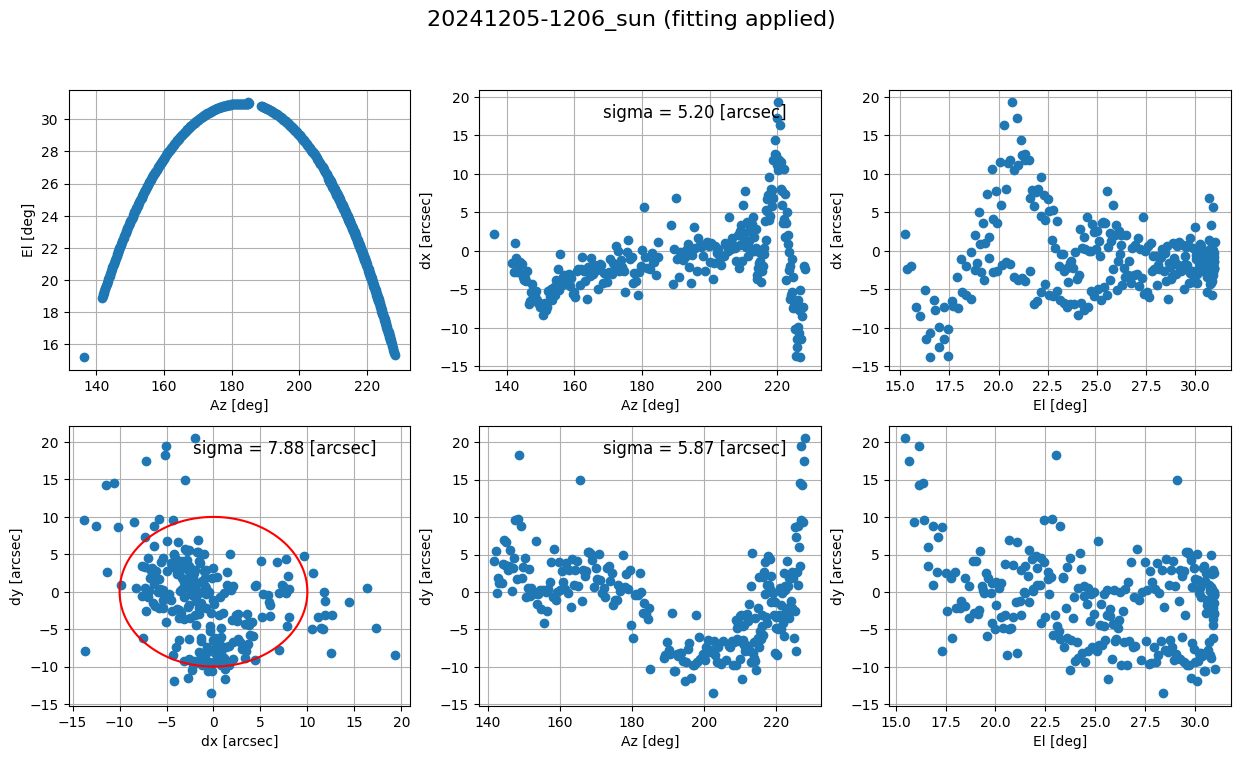

In [50]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]

ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(csv['Az'], csv['dx']-bestfit_dx, 'o')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(csv['El'], csv['dx']-bestfit_dx, 'o')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(csv_union['dx']-bestfit_union_dx, csv_union['dEl']-bestfit_union_dy, 'o')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dy [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(csv['Az'], csv['dEl']-bestfit_dy, 'o')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dy [arcsec]')
ax[4].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(csv['El'], csv['dEl']-bestfit_dy, 'o')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dy [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle(f"{str(save_path.name)} (fitting applied)", fontsize=16)
fig.savefig(figs / "pointing_fitting_applied.png")

In [114]:
csv['dEl']-bestfit_dy

0          NaN
1    -5.316304
2          NaN
3    -5.254930
4          NaN
        ...   
84   -3.248676
85         NaN
86   -3.238103
87         NaN
88    7.449114
Length: 89, dtype: float64

In [115]:
print(pp4.x)
print(pp4.x.T)

[-0.00107907 -0.00012249  0.00414433 -0.00797847]
[-0.00107907 -0.00012249  0.00414433 -0.00797847]


In [116]:
# a1, a2, a3, b1, b2, b3, g1 の変化量を決定して出力
# dkisa_array = pp3.x.T/3600 * -1  # 符号の反転を直す
if len(pp4.x) != 4:
    raise ValueError("pp4.x must have 4 elements.")
a1 = pp3.x[0] * u.deg
a2 = pp3.x[1] * u.deg
a3 = pp3.x[2] * u.deg
b1 = pp3.x[3] * u.deg
b2 = pp3.x[4] * u.deg
b3 = pp3.x[5] * u.deg
g1 = pp3.x[6]
c1 = pp4.x[0] * u.deg
c2 = pp4.x[1] * u.deg
d1 = pp4.x[2] * u.deg
d2 = pp4.x[3] * u.deg
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20241209_sun/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.0
"a2[deg]" = 0.0
"a3[deg]" = 0.0
"b1[deg]" = 0.0
"b2[deg]" = 0.0
"b3[deg]" = 0.0
g1 = 0.0
"c1[deg]" = -0.0010790722451697013
"c2[deg]" = -0.00012249117796082575
"d1[deg]" = 0.004144332155118262
"d2[deg]" = -0.007978473860605937
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [117]:
# arcsec でも一応出力
write_param(data_dir / "pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="arcsec")
# dkisa_array = pp3.x.T * -1  # 符号の反転を直す
# a1 = dkisa_array[0] * u.arcsec
# a2 = dkisa_array[1] * u.arcsec
# a3 = dkisa_array[2] * u.arcsec
# b1 = dkisa_array[3] * u.arcsec
# b2 = dkisa_array[4] * u.arcsec
# b3 = dkisa_array[5] * u.arcsec
# g1 = dkisa_array[6]/3600
# c1 = 0.0 * u.deg
# c2 = 0.0 * u.deg
# d1 = 0.0 * u.deg
# d2 = 0.0 * u.deg
# e1 = 0.0 * u.deg
# e2 = 0.0 * u.deg
# write_param(f"{data_dir}/pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20241209_sun/pointing_param_delta_arcsec.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[arcsec]" = 0.0
"a2[arcsec]" = 0.0
"a3[arcsec]" = 0.0
"b1[arcsec]" = 0.0
"b2[arcsec]" = 0.0
"b3[arcsec]" = 0.0
g1 = 0.0
"c1[arcsec]" = -3.8846600826109245
"c2[arcsec]" = -0.4409682406589727
"d1[arcsec]" = 14.919595758425743
"d2[arcsec]" = -28.722505898181375
"e1[arcsec]" = 0.0
"e2[arcsec]" = 0.0



In [118]:
# 変化後の器差を出力
apply_kisa() 

======= PosixPath('20241209_sun/pointing_param_after.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = -0.017297889370905258
"a2[deg]" = 0.019932118906155788
"a3[deg]" = 2.4235584317039462
"b1[deg]" = 0.007318911360098779
"b2[deg]" = -0.004695853513104079
"b3[deg]" = -0.6856095218516536
g1 = 0.0001613560772320849
"c1[deg]" = -0.0010790722451697013
"c2[deg]" = -0.00012249117796082575
"d1[deg]" = -0.014254326792277734
"d2[deg]" = 0.09204277410854912
"e1[deg]" = 0.0
"e2[deg]" = 0.0



# d1, d2 の計算
本来の電波ポインティングで行う器差補正<br>
前の a1, a2, a3, b1, b2, b3, g1 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- d1：電波光学系とガイド光学望遠鏡の Az 方向のオフセット (dAz の単純平均)
- d2：電波光学系とガイド光学望遠鏡の El 方向のオフセット (dEl の単純平均)

c1, c2, e1, e2 はずっと 0 で変更されていない？
- c1：光学系の軸とホーン位置の東西方向のズレ
- c2：光学系の軸とホーン位置の南北方向のズレ
- e1：情報なし
- e2：情報なし

In [41]:
# NaNを無視して平均を計算
mean_dAz = csv_az["dx"].mean() * u.arcsec
mean_dEl = csv_el["dEl"].mean() * u.arcsec
print(f"mean_dx = {mean_dAz}")
print(f"mean_dy = {mean_dEl}")

mean_dx = -0.04075665114325934 arcsec
mean_dy = 0.8949627607448499 arcsec


In [42]:
# d1, d2 の変化量を決定して出力
a1 = 0.0 * u.deg
a2 = 0.0 * u.deg
a3 = 0.0 * u.deg
b1 = 0.0 * u.deg
b2 = 0.0 * u.deg
b3 = 0.0 * u.deg
g1 = 0.0
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = mean_dAz.to(u.deg)
d2 = mean_dEl.to(u.deg)
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)

print(f"d1 = {d1}")
print(f"d2 = {d2}")

======= PosixPath('20241205-1206_sun/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.0
"a2[deg]" = 0.0
"a3[deg]" = 0.0
"b1[deg]" = 0.0
"b2[deg]" = 0.0
"b3[deg]" = 0.0
g1 = 0.0
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -1.1321291984238705e-05
"d2[deg]" = 0.00024860076687356945
"e1[deg]" = 0.0
"e2[deg]" = 0.0

d1 = -1.1321291984238705e-05 deg
d2 = 0.00024860076687356945 deg


In [43]:
write_param(data_dir / "pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="arcsec")

======= PosixPath('20241205-1206_sun/pointing_param_delta_arcsec.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[arcsec]" = 0.0
"a2[arcsec]" = 0.0
"a3[arcsec]" = 0.0
"b1[arcsec]" = 0.0
"b2[arcsec]" = 0.0
"b3[arcsec]" = 0.0
g1 = 0.0
"c1[arcsec]" = 0.0
"c2[arcsec]" = 0.0
"d1[arcsec]" = -0.04075665114325934
"d2[arcsec]" = 0.89496276074485
"e1[arcsec]" = 0.0
"e2[arcsec]" = 0.0



In [44]:
a = 50 * u.arcmin
print(a.to(u.arcsec).value)

3000.0


In [45]:
# 変化後の器差を出力
apply_kisa()

======= PosixPath('20241205-1206_sun/pointing_param_after.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = -0.017297889370905258
"a2[deg]" = 0.019932118906155788
"a3[deg]" = 2.4235584317039462
"b1[deg]" = 0.007318911360098779
"b2[deg]" = -0.004695853513104079
"b3[deg]" = -0.6856095218516536
g1 = 0.0001613560772320849
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.018409980239380234
"d2[deg]" = 0.10026984873602862
"e1[deg]" = 0.0
"e2[deg]" = 0.0

